# 05 훈련하는 노하우를 배웁니다

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 05-1 검증 세트를 나누고 전처리 과정을 배웁니다 
--> 테스트 세트의 사용 방법에 대해 더 깊이 알아봄

**테스트 세트로 모델을 튜닝합니다**

로지스틱 회귀로 모델 훈련하고 평가하기

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)

SGDClassifier클래스를 이용하여 로지스틱 회귀 모델 훈련하기 <br>
>fit()메서드에 x_train_all, y_train_all을 전달하여 모델 훈련 <br>
score()메서드에 x_test, y_test를 전달하여 성능 평가

In [3]:
from sklearn.linear_model import SGDClassifier

In [4]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

서포트 벡터 머신으로 모델 훈련하고 평가하기 

In [6]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

--> SGDClassifier 클래스의 loss 매개변수를 log에서 hinge로 바꾸면 선형 서포트 벡터 머신 문제를 푸는 모델이 만들어짐. 

**검증 세트를 준비합니다** <br>
테스트 세트는 모델 튜닝을 모두 마치고 실전에 투입하기 전에 딱 한번만 사용하는 것이 좋다. <br>
--> 즉, 모델 튜닝을 위해 훈련 세트에서 <span style = "color:red">검증 세트</span>를 조금 떼어 만든다.

1) 데이터 세트 준비하기  <br>
이번에도 위스콘신 유방암 데이터 사용

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

2) 검증 세트 분할하기 <br>
>전체 데이터 세트를 8:2로 나누어 훈련세트와 테스트 세트를 만들고 <br>
다시 훈련 세트를 8:2로 나누어 훈련 세트와 검증 세트를 만든다.

In [8]:
print(len(x_train), len(x_val))

364 91


3) 검증 세트 사용해 모델 평가하기

In [9]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

> 훈련 세트가 줄어들었기 때문에 평가 점수가 낮아짐. <br>
--> 데이터 양이 너무 적은 경우에는 검증 세트를 나누지 않고 교차 검증 방법 사용 <br>
--> 일반적으로 검증과 테스트 세트의 샘플 수를 1만 개 이상 확보할 수 있다면 훈련 세트에 많은 샘플을 할당하는 것이 좋음

**데이터 전처리와 특성의 스케일을 알아봅니다**
> 특성의 스케일은 알고리즘에 영향을 주기 때문에 전처리 필요

**스케일을 조정하지 않고 모델을 훈련해 볼까요?**

1) 훈련 데이터 준비하고 스케일 비교하기 

['mean perimeter' 'mean area']


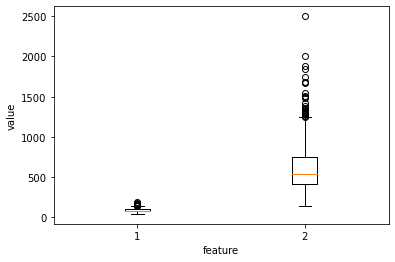

In [10]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

2) 가중치를 기록할 변수와 학습률 파라미터 추가하기
> init() 메서드에서 인스턴스 변수 w_history를 만들고 학습률 파라미터 learning_rate를 추가 <br>

3) 가중치 기록하고 업데이트 양 조절하기 
> fit() 메서드에서 가중치가 바뀔때마다 w_history 리스트에 가중치를 기록. <br>
넘파이 배열을 리스트에 추가하면 실제 값이 복사되는 것이 아니라 배열을 참조하기 때문에 가중치 변수 self.w의 값이 바뀔 때마다 그 값을 복사하여 w_history 리스트에 추가해야 함. <br>
또, w_grad에 학습률 self.lr을 곱하는 연산이 추가되어 가중치 업데이트 양을 조절함

In [11]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

4) 모델 훈련하고 평가하기

In [12]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

5) layer1 객체의 인스턴스 변수 w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록되어있다. 이때 세 번째, 네 번째 요소 (w[2], w[3])는 각각 mean_perimeter와 mean area 특성에 대한 가중치이다.

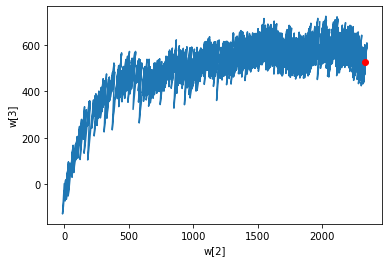

In [15]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
# 최종 가중치는 빨간 점
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 불안정하게 수렴하는 것이 보임

**스케일을 조정해 모델을 훈련합니다** <br>

1) 넘파이로 표준화 구현하기 

In [16]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

2) 모델 훈련하기 
> 스케일을 조정한 데이터 세트로 단일층 신경망을 다시 훈련시키고 가중치를 그래프로 그려보기

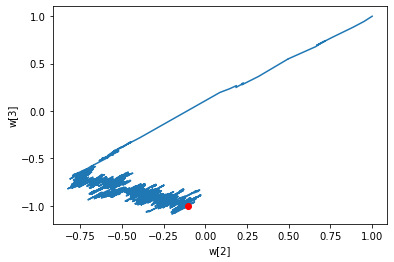

In [18]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 최적값에 빠르게 근접하고 있는 것이 보임

3) 모델 성능 평가하기 

In [19]:
layer2.score(x_val, y_val)

0.37362637362637363

4) 검증 세트의 스케일을 바꾸지 않았기 때문에 성능이 나쁘게 나옴. 
> 검증 세트도 표준화 전처리를 해볼 것

In [20]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

layer2.score(x_val_scaled, y_val)

0.967032967032967

**스케일을 조정한 다음에 실수하기 쉬운 함정을 알아봅니다**
> 함정 : 훈련세트와 검증 세트가 다른 비율로 스케일이 조정된 경우 

1) 원본 훈련 세트와 검증 세트로 산점도 그리기 
> <span style="color:blue">훈련 세트</span> , <span style="color:red">검증 세트</span>

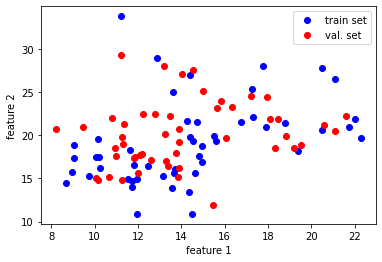

In [21]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

2) 전처리한 훈련 세트와 검증 세트로 산점도 그리기

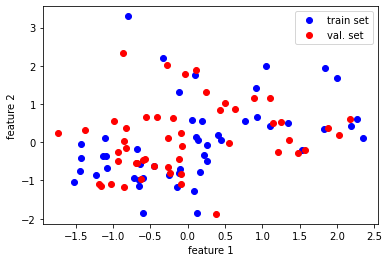

In [22]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

---> 점과 점 사이의 거리가 달라진 이유 : 훈련 세트와 검증 세트를 각각 다른 비율로 처리했기 때문

3) 올바르게 검증 세트 전처리하기
> 검증 세트를 훈련 세트와 같은 비율로 전처리 해야함. --> 훈련 세트의 평균, 표준 편차를 사용하여 검증 세트를 변환하면 됨

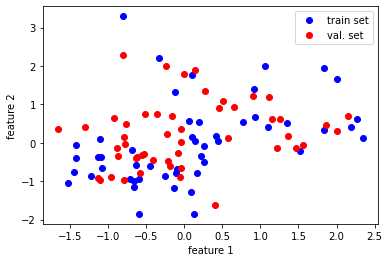

In [23]:
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

4) 모델 평가하기 

In [24]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

***
<br>

## 05-2 과대적합과 과소적합을 알아봅니다

> **과대적합** : 모델이 훈련 세트에서는 좋은 성능을 내지만 검증 세트에서는 낮은 성능을 내는 경우

> **과소적합** : 훈련 세트와 검증 세트의 성능에는 차이가 크지 않지만 모두 낮은 성능을 내는 경우

**적절한 편향-분산 트레이드오프를 선택합니다**

1) 검증 손실을 기록하기 위한 변수 추가하기
> SingleLayer클래스의 __init__() 메서드에 self.val_losses 인스턴스 변수 추가 

2) fit() 메서드에 검증 세트를 전달받을 수 있도록 x_val, y_val 매개변수를 추가 (위에서 했음)

3) 검증 손실 계산하기
> update_val_loss() 메서드에서 검증 손실 계산

4) 모델 훈련하기
> 모델의 수정을 완료했으므로 표준화(전처리)된 훈련 세트와 검증 세트를 이용하여 단일층 신경망 훈련

In [25]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

5) 손실값으로 그래프 그려 에포크 횟수 지정하기

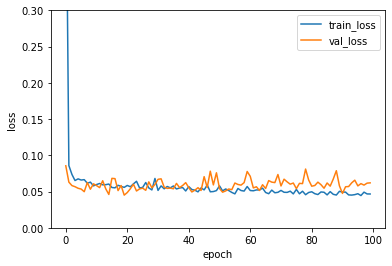

In [26]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

6) 훈련 조기 종료하기
> 그래프에서 대략 20번째 에포크 이후에 검증 손실이 훈련 세트보다 높아짐. <br>
--> 에포크가 진행됨에 따라 가중치는 훈련 세트에 잘 맞게 되지만 검증 세트에는 잘 맞지 않게 되는 것